In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import dtale  # Удобная библиотека для просмотра и анализа
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Дополнительные функции

In [2]:
def IQR_for_column(column):
    """Функция возвращает квартили и выводит границы для выбросов, согласно IQR"""
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    print(
    '25-й перцентиль: {} |'.format(perc25),
    '75-й перцентиль: {} |'.format(perc75),
    "IQR: {} | ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

In [3]:
def log_graf_col(column):
    """Функция для построения логарифмического графика для уменьшения правого хвоста"""
    plt.figure()
    sns.set(font_scale=1)
    plt.subplots(figsize=(18,6))
    sns.distplot(data[column][data[column] > 0].dropna(), kde = False, rug=False)
    plt.title(column)
    plt.show()

# Обзор данных

In [4]:
data = pd.read_csv('train.csv')
data.sample(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
45194,96037,SCH,F,35,N,N,0,1,1,2,3,14000,N,0
45581,67394,UGR,M,31,Y,N,1,0,4,2,3,15000,N,0
54849,61110,GRD,F,56,N,N,0,1,3,1,2,18000,N,0
67245,6365,SCH,F,37,Y,Y,0,0,0,1,2,40000,N,0
67838,108315,GRD,M,26,N,N,0,1,0,1,2,28000,N,0
23557,39475,SCH,F,42,N,N,0,0,0,1,2,30000,N,0
50416,9552,SCH,F,54,Y,Y,0,0,0,1,3,40000,N,0
6219,57568,SCH,M,51,N,N,1,0,0,2,3,40000,N,0
7381,3221,GRD,M,25,N,N,0,0,3,1,2,30000,N,0
38833,101860,SCH,M,39,N,N,0,0,1,2,3,30000,N,0


In [5]:
#d = dtale.show(data)
#d

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [7]:
data.describe()

,client_id,age,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,2.000339,1.575509,2.496280,41099.775417,0.126994
std,31841.921168,11.520378,0.804272,0.371087,2.252073,0.527631,0.689818,46166.322400,0.332968
min,1.000000,21.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1000.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,0.000000,1.000000,2.000000,20000.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,1.000000,2.000000,3.000000,30000.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,3.000000,2.000000,3.000000,48000.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,53.000000,3.000000,3.000000,1000000.000000,1.000000


In [8]:
# Подсчёт пропусков в столбцах
data.isnull().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

# Изучение каждого признака отдельно

## default

0    64427
1     9372
Name: default, dtype: int64

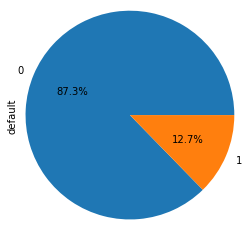

In [9]:
display(data.default.value_counts())
data.default.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

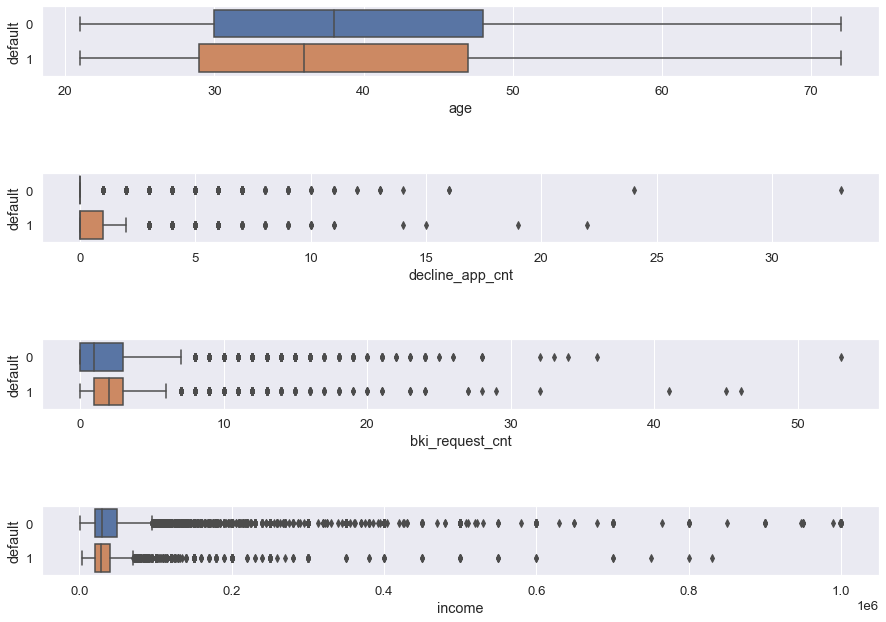

In [10]:
sns.set(font_scale=1.2)
plt.subplots(figsize=(15,12))

plt.subplot(8, 1, 1)
sns.boxplot(y=data.default, x=data['age'], orient='h')

plt.subplot(8, 1, 3)
sns.boxplot(y=data.default, x=data['decline_app_cnt'], orient='h')

plt.subplot(8, 1, 5)
sns.boxplot(y=data.default, x=data['bki_request_cnt'], orient='h')

plt.subplot(8, 1, 7)
sns.boxplot(y=data.default, x=data['income'], orient='h')
plt.show()

Только 12.7% имели дефолт

## client_id

In [11]:
data.client_id.value_counts()

6141     1
42113    1
29467    1
19228    1
21279    1
        ..
46588    1
48637    1
42494    1
87552    1
2049     1
Name: client_id, Length: 73799, dtype: int64

У каждого клиента свой идентификационный номер. С большой вероятностью этот признак можно не вносить в модель

## Sex

In [12]:
data.sex.value_counts()

F    41562
M    32237
Name: sex, dtype: int64

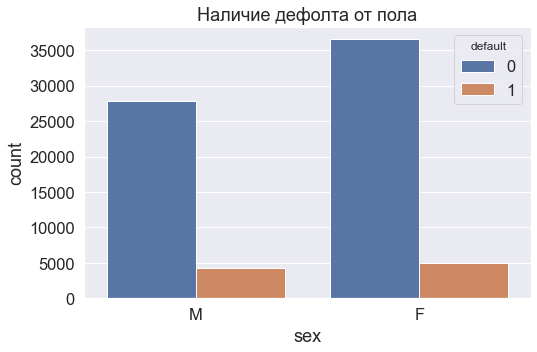

In [13]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(8,5))
plt.title('Наличие дефолта от пола')
sns.countplot(x="sex", hue="default", data=data)

## Age

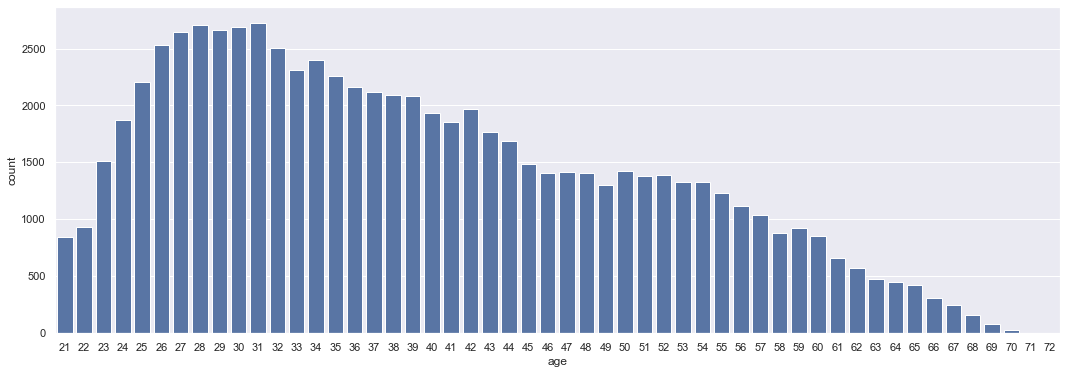

In [14]:
sns.set(font_scale=1)
plt.subplots(figsize=(18,6))
sns.countplot(x=data.age, color='b')

<Figure size 432x288 with 0 Axes>

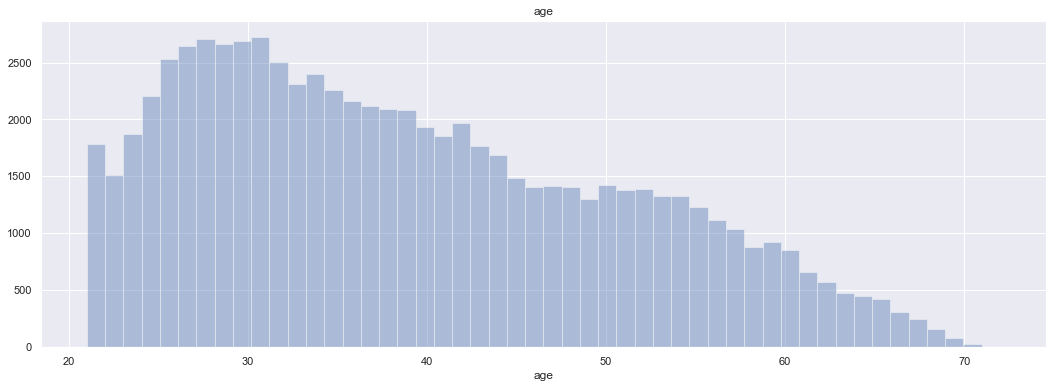

In [15]:
log_graf_col('age')

In [16]:
IQR_for_column('age')

25-й перцентиль: 30.0 | 75-й перцентиль: 48.0 | IQR: 18.0 |  Границы выбросов: [3.0, 75.0].


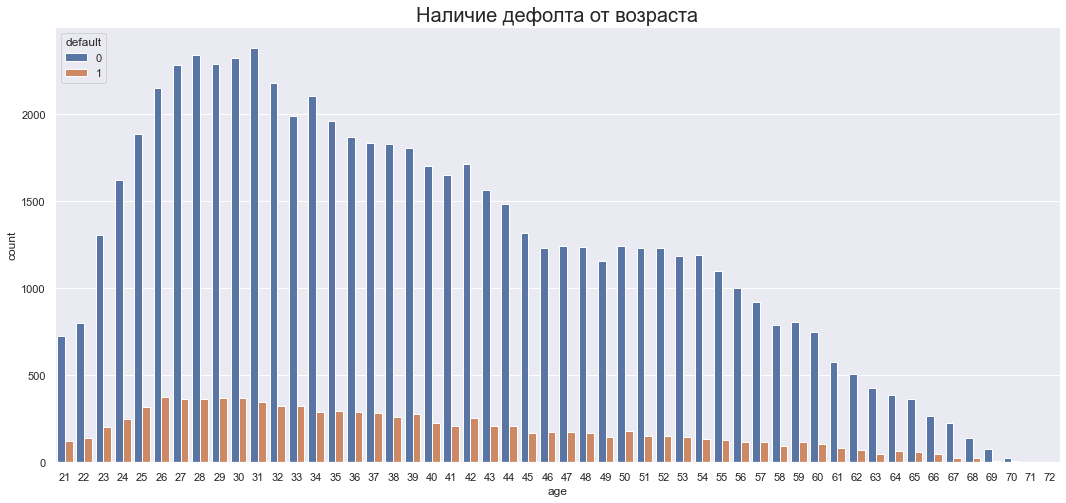

In [17]:
sns.set(font_scale=1)
plt.subplots(figsize=(18,8))
plt.title('Наличие дефолта от возраста', fontsize=20)
sns.countplot(x="age", hue="default", data=data)

## Car

In [18]:
data.car.value_counts()

N    49832
Y    23967
Name: car, dtype: int64

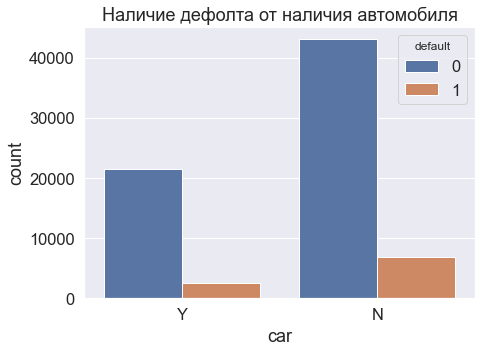

In [19]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(7,5))
plt.title('Наличие дефолта от наличия автомобиля')
sns.countplot(x="car", hue="default", data=data)

## Car type

In [20]:
data.car_type.value_counts()

N    59791
Y    14008
Name: car_type, dtype: int64

In [21]:
# Проверка на ошибку, когда в колонке car (наличие автомобиля) 'N', а в колонке car_type (иномарка или нет) 'Y'.
print('Найдено ошибок -' , len(data[(data.car_type=='Y')&(data.car_type=='N')]))

Найдено ошибок - 0


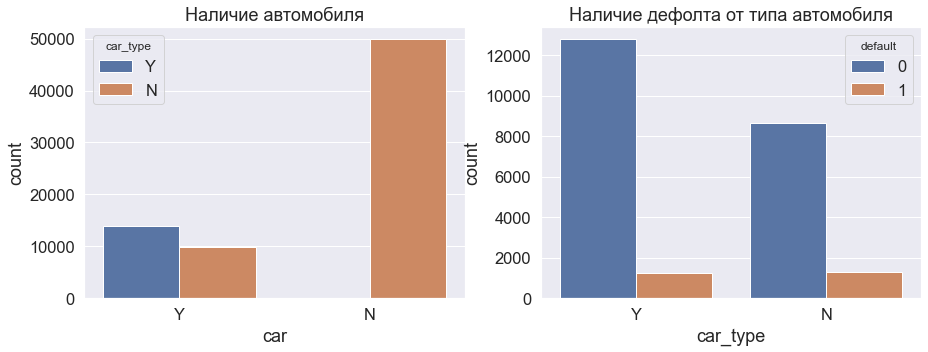

In [22]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('Наличие автомобиля')
sns.countplot(x="car", hue="car_type", data=data)

plt.subplot(1, 2, 2)
plt.title('Наличие дефолта от типа автомобиля')
sns.countplot(x="car_type", hue="default", data=data[data.car=='Y'])

## Decline app cnt

In [23]:
data.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

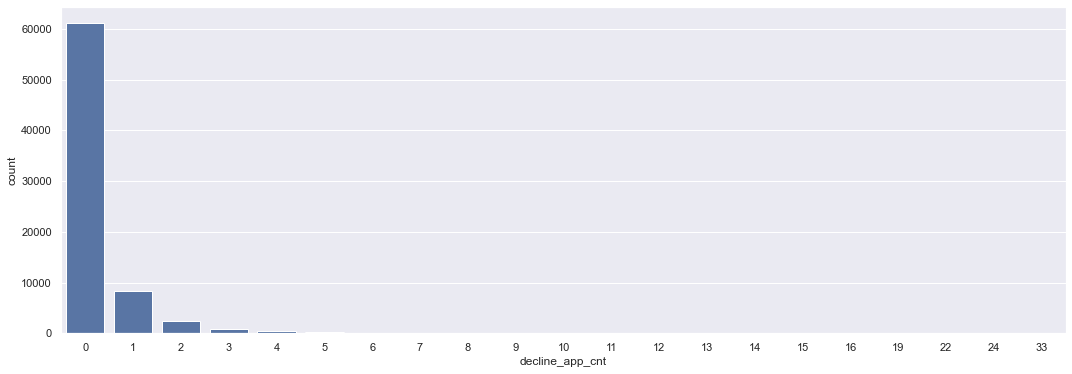

In [24]:
sns.set(font_scale=1)
plt.subplots(figsize=(18,6))
sns.countplot(x=data.decline_app_cnt, color='b')

<Figure size 432x288 with 0 Axes>

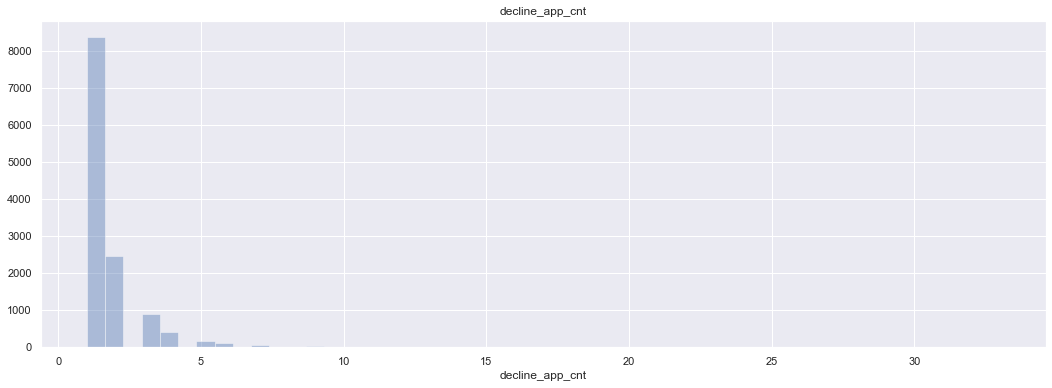

In [25]:
log_graf_col('decline_app_cnt')

In [26]:
IQR_for_column('decline_app_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | IQR: 0.0 |  Границы выбросов: [0.0, 0.0].


## Good work

In [27]:
data.good_work.value_counts()

0    61630
1    12169
Name: good_work, dtype: int64

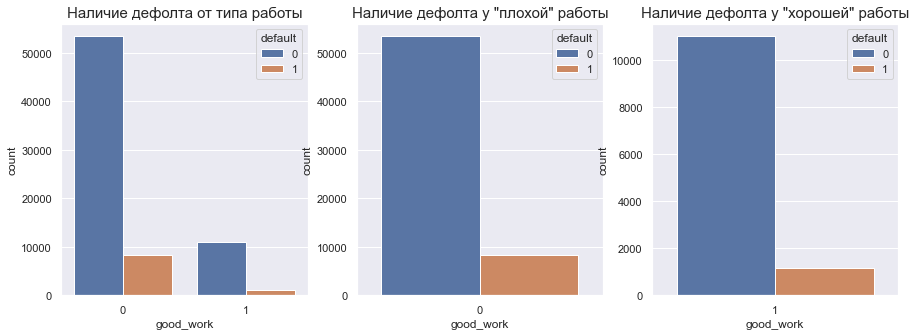

In [28]:
sns.set(font_scale=1)
plt.subplots(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.title('Наличие дефолта от типа работы', fontsize=15)
sns.countplot(x="good_work", hue="default", data=data)

plt.subplot(1, 3, 2)
plt.title('Наличие дефолта у "плохой" работы', fontsize=15)
sns.countplot(x="good_work", hue="default", data=data[data.good_work==0])

plt.subplot(1, 3, 3)
plt.title('Наличие дефолта у "хорошей" работы', fontsize=15)
sns.countplot(x="good_work", hue="default", data=data[data.good_work==1])

## Bki request cnt

In [29]:
data.bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
28        4
22        4
32        2
27        2
26        2
25        2
46        1
29        1
33        1
34        1
36        1
41        1
45        1
53        1
Name: bki_request_cnt, dtype: int64

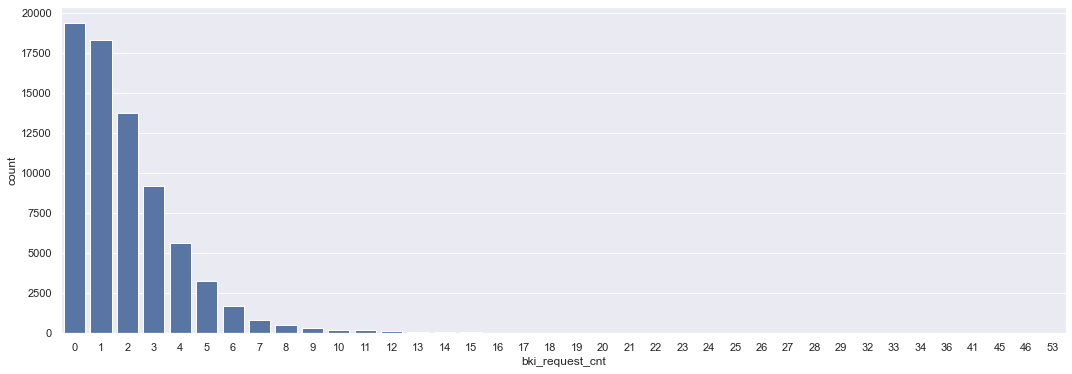

In [30]:
sns.set(font_scale=1)
plt.subplots(figsize=(18,6))
sns.countplot(x=data.bki_request_cnt, color='b')

<Figure size 432x288 with 0 Axes>

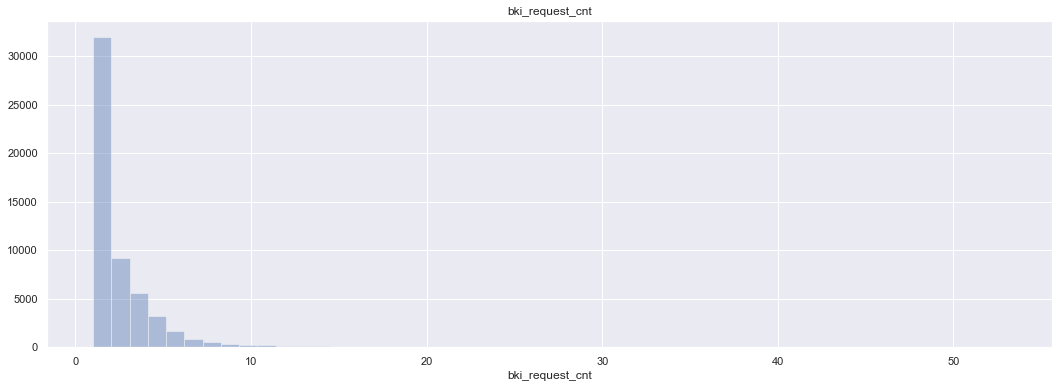

In [31]:
log_graf_col('bki_request_cnt')

In [32]:
IQR_for_column('bki_request_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 3.0 | IQR: 3.0 |  Границы выбросов: [-4.5, 7.5].


## Home and work address

In [33]:
data.home_address.value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

In [34]:
data.work_address.value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

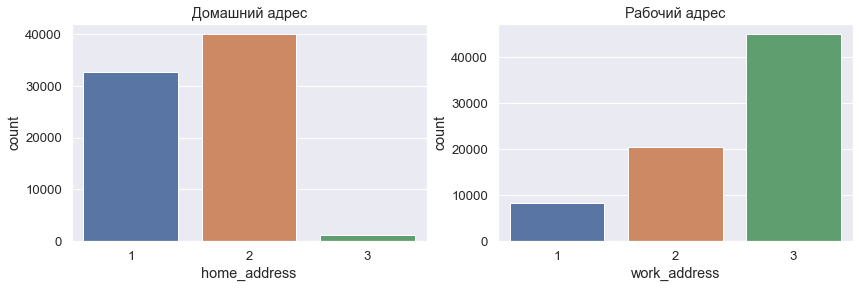

In [35]:
sns.set(font_scale=1.2)
plt.subplots(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.title('Домашний адрес')
sns.countplot(x="home_address", data=data)

plt.subplot(1, 2, 2)
plt.title('Рабочий адрес')
sns.countplot(x="work_address", data=data)

In [37]:
dummy_home_address = pd.get_dummies(data.home_address)
data = pd.concat([data, dummy_home_address], axis=1).drop('home_address', axis=1)

In [38]:
dummy_work_address = pd.get_dummies(data.work_address)
data = pd.concat([data, dummy_work_address], axis=1).drop('work_address', axis=1)

In [39]:
data.sample(6)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,income,foreign_passport,default,1,2,3,1,2,3
1739,9175,NaN,F,43,Y,N,0,0,0,9000,N,0,0,1,0,0,0,1
19937,13078,SCH,F,39,N,N,0,0,4,15000,N,0,1,0,0,0,1,0
4659,13038,GRD,F,33,N,N,0,0,0,40000,N,1,0,1,0,0,0,1
1077,63872,GRD,F,64,N,N,0,0,5,10000,N,0,0,1,0,0,0,1
41718,8514,UGR,F,31,N,N,0,0,1,80000,N,0,0,1,0,0,0,1
34789,10940,SCH,F,38,N,N,0,0,0,30000,N,0,1,0,0,1,0,0


## Income

In [ ]:
#sns.set(font_scale=1)
#plt.subplots(figsize=(18,6))
#plt.xticks(np.arange(1000, 1000000, step=500000))
#sns.countplot(x=data.income, color='b')

In [40]:
len(data.income.value_counts())

966

<Figure size 432x288 with 0 Axes>

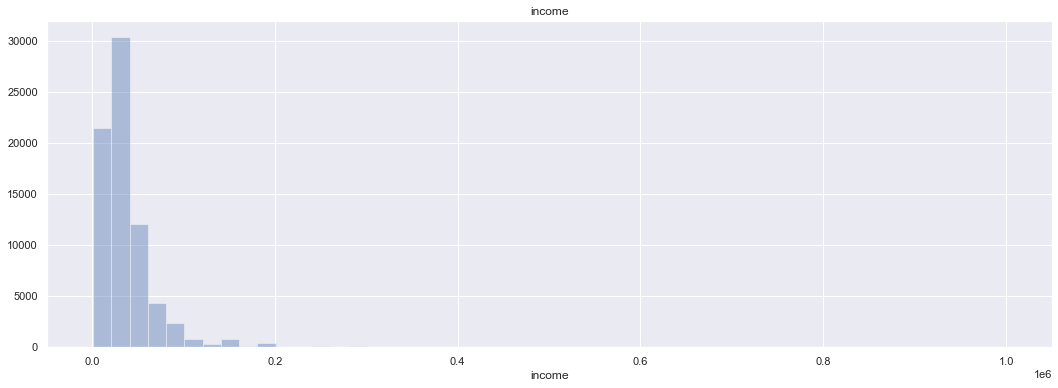

In [41]:
log_graf_col('income')

In [42]:
IQR_for_column('income')

25-й перцентиль: 20000.0 | 75-й перцентиль: 48000.0 | IQR: 28000.0 |  Границы выбросов: [-22000.0, 90000.0].


In [43]:
# Выбросов согластно IQR
len(data[data['income']>90000])

4695

## Foreign passport

In [44]:
data.foreign_passport.value_counts()

N    62733
Y    11066
Name: foreign_passport, dtype: int64

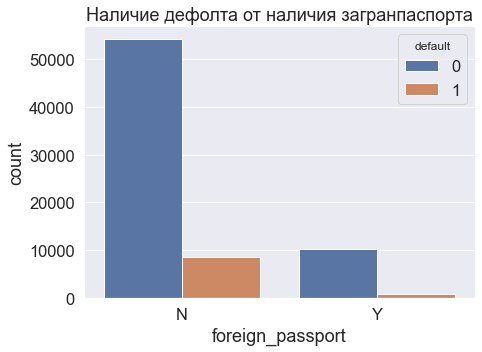

In [45]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(7,5))
plt.title('Наличие дефолта от наличия загранпаспорта')
sns.countplot(x="foreign_passport", hue="default", data=data)

## Education

In [46]:
data.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

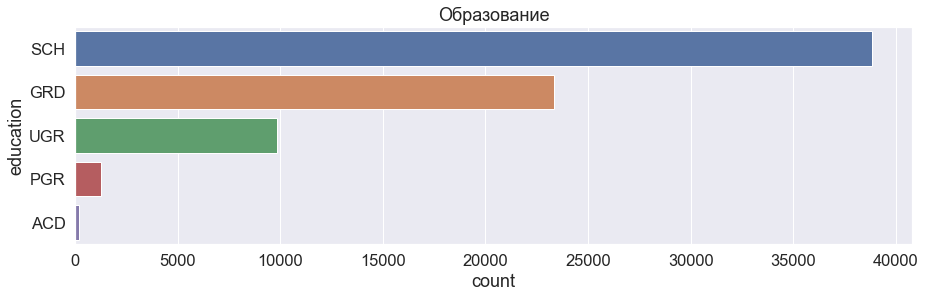

In [47]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(15,4))
plt.title('Образование')
sns.countplot(y="education", data=data)

In [48]:
dummy_education = pd.get_dummies(data.education, dummy_na=True)
data = pd.concat([data, dummy_education], axis=1).drop('education', axis=1)

In [49]:
data.sample(6)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,income,foreign_passport,...,3,1,2,3,ACD,GRD,PGR,SCH,UGR,NaN
53608,95801,M,49,Y,N,1,0,10,80000,N,...,0,0,0,1,0,1,0,0,0,0
43657,9326,F,51,N,N,2,1,9,35000,N,...,0,1,0,0,0,1,0,0,0,0
11613,29365,M,23,N,N,0,0,4,40000,N,...,0,0,1,0,0,0,0,1,0,0
71019,89100,F,43,N,N,0,1,0,40000,Y,...,0,1,0,0,0,1,0,0,0,0
47300,21460,F,45,N,N,1,0,6,35000,N,...,0,0,1,0,0,1,0,0,0,0
3165,76036,F,50,N,N,0,0,0,20000,N,...,0,1,0,0,0,1,0,0,0,0


In [50]:
# Заполнили пропуски в образовании
#data.education.fillna('no_info', inplace=True)
#data.education.value_counts()

# Дальнейшая работа

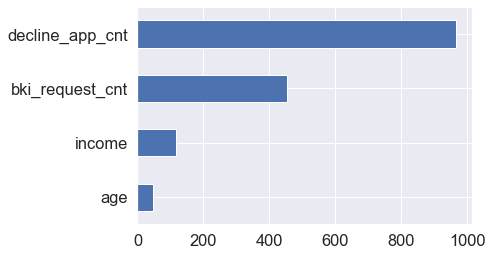

In [51]:
# Значимость для числовых признаков
num_cols = data[['age', 'decline_app_cnt', 'bki_request_cnt', 'income']]
imp_num = pd.Series(f_classif(num_cols, data['default'])[0],
                    index = ('age', 'decline_app_cnt', 'bki_request_cnt', 'income'))
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [52]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,income,foreign_passport,...,3,1,2,3,ACD,GRD,PGR,SCH,UGR,NaN
0,25905,1,62,1,1,0,0,1,18000,0,...,0,0,1,0,0,0,0,1,0,0
1,63161,0,59,0,0,0,0,3,19000,0,...,0,0,0,1,0,0,0,1,0,0
2,25887,1,25,1,0,2,0,1,30000,1,...,0,0,1,0,0,0,0,1,0,0
3,16222,0,53,0,0,0,0,2,10000,0,...,0,0,0,1,0,0,0,1,0,0
4,101655,1,48,0,0,0,1,1,30000,1,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
# Значимость для бинарных и категориальных
bin_and_cat_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'home_address', 'work_address']
imp_cat = Series(mutual_info_classif(data[bin_and_cat_cols], data['default'],
                                     discrete_features =True), index = bin_and_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [53]:
data.sample(5)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,income,foreign_passport,...,3,1,2,3,ACD,GRD,PGR,SCH,UGR,NaN
37356,21643,0,28,0,0,0,0,5,28000,0,...,0,0,0,1,0,0,0,1,0,0
31744,37461,1,24,0,0,0,0,2,40000,0,...,0,0,1,0,0,1,0,0,0,0
57229,82695,0,68,0,0,0,0,1,9000,0,...,0,0,0,1,0,1,0,0,0,0
53622,8710,0,41,0,0,0,1,1,51800,0,...,0,0,0,1,0,0,0,1,0,0
2630,73434,1,55,1,0,7,0,7,20000,0,...,0,0,0,1,0,0,0,0,1,0


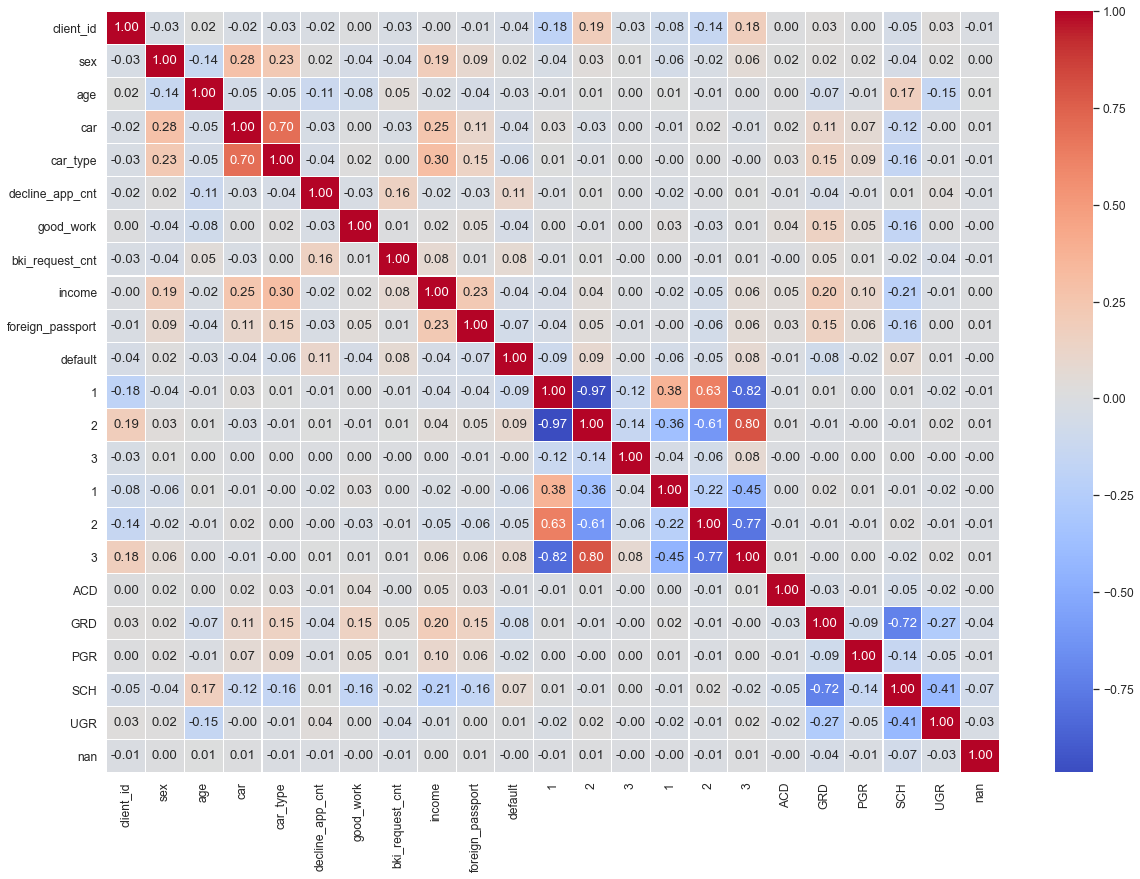

In [56]:
sns.set(font_scale=1.1)
plt.subplots(figsize=(20,14))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

In [ ]:
sns.set(font_scale=1.1)
plt.subplots(figsize=(15,6))
sns.heatmap(data.corr(), annot=True, fmt='.3f', linewidths=0.1, cmap="coolwarm")

In [ ]:
data.sex.value_counts()

In [ ]:
data.car.value_counts()

In [ ]:
data.sample(10)

In [ ]:
data.car_type.value_counts()

In [ ]:
data.foreign_passport.value_counts()

In [ ]:
pd.get_dummies?